# Downloading & cleaning the data:

In [1]:
from utils import (min_amount, explained_variance, create_transformed_df, post_pca_train_test_data)
from unit_tests import (test_min_amount)

import pandas as pd
import numpy as np
import os

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import boto3
import sagemaker
from sagemaker import PCA
from sagemaker import get_execution_role

!pip install mxnet
import mxnet as mx

import torch

    100% |████████████████████████████████| 25.4MB 2.0MB/s eta 0:00:01     | 7.4MB 51.4MB/s eta 0:00:01
    100% |████████████████████████████████| 20.0MB 3.2MB/s eta 0:00:01
fastai 1.0.55 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [292]:
data_dir = './data/'
train_file = 'train.csv'

In [293]:
train = pd.read_csv(os.path.join(data_dir, train_file))

In [294]:
test_min_amount(min_amount)

cols_to_remove = min_amount(train, 0.8)

test passed !


In [295]:
train_dropna = train.drop(cols_to_remove, axis=1).dropna()

In [296]:
cat_cols = train_dropna.select_dtypes(include='object').columns.tolist()

In [297]:
for col in cat_cols:
    train_dropna[col] = pd.Categorical(train_dropna[col])
    train_dropna[col] = train_dropna[col].cat.codes

# Univariate Feature Selection: 

Feature selection method that allows you to pick the top N most important variables given the explanatory power with respect to the dependent variable.

In [316]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train_dropna.iloc[:,:-1]  
y = train_dropna.iloc[:,-1]

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

           Specs         Score
4        LotArea  5.916728e+06
70       MiscVal  8.017426e+05
43      2ndFlrSF  3.677933e+05
33    BsmtFinSF1  3.372335e+05
35    BsmtFinSF2  3.024161e+05
25    MasVnrArea  2.422697e+05
36     BsmtUnfSF  2.156723e+05
44  LowQualFinSF  2.081572e+05
69      PoolArea  1.998745e+05
67     3SsnPorch  1.610337e+05


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


- **LotArea**: Lot size in square feet
- **MiscVal** : Value of miscellaneous feature (not covered in other categories)
- **2ndFlrSF**: Second floor square feet
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinSF2**: Type 2 finished square feet
- **MasVnrArea**: Masonry veneer area in square feet
- **BsmtUnfSF**: Unfinished square feet of basement area
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **PoolArea**: Pool area in square feet
- **3SsnPorch**: Three season porch area in square feet

In [325]:
train_dropna[featureScores.nlargest(10,'Score')['Specs'].tolist()].describe()

,LotArea,MiscVal,2ndFlrSF,BsmtFinSF1,BsmtFinSF2,MasVnrArea,BsmtUnfSF,LowQualFinSF,PoolArea,3SsnPorch
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,10132.346435,23.550274,356.536563,448.191956,45.252285,109.855576,606.117002,4.680987,3.007313,3.266910
std,8212.249621,167.135237,439.260130,468.728095,159.075003,190.667459,445.834636,42.099821,40.713175,29.655973
min,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7606.750000,0.000000,0.000000,0.000000,0.000000,0.000000,270.000000,0.000000,0.000000,0.000000
50%,9444.500000,0.000000,0.000000,384.500000,0.000000,0.000000,525.000000,0.000000,0.000000,0.000000
75%,11387.250000,0.000000,729.000000,712.750000,0.000000,171.750000,846.000000,0.000000,0.000000,0.000000
max,215245.000000,2500.000000,2065.000000,5644.000000,1474.000000,1600.000000,2336.000000,572.000000,648.000000,508.000000


# Uploading data  to S3

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dropna.iloc[:,:-1], train_dropna.iloc[:,-1:], test_size=0.2, random_state=42)

In [16]:
data_dir = 'model_data'
train_pca_output_filename = 'train_raw.csv'
test_pca_output_filename = 'test_raw.csv'

train_pca_output = pd.concat(
    [pd.DataFrame(y_train),pd.DataFrame(X_train)], axis=1).to_csv(
    os.path.join(data_dir, train_pca_output_filename), header=None, index=False)

test_pca_output = pd.concat(
    [pd.DataFrame(y_test),pd.DataFrame(X_test)], axis=1).to_csv(
    os.path.join(data_dir, test_pca_output_filename), header=None)

In [17]:
X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
634,635,90,3,64.0,6979,1,3,3,0,4,...,56,0,0,0,0,600,6,2010,8,4
194,195,20,3,60.0,7180,1,0,3,0,4,...,0,0,0,0,0,0,5,2008,8,4
117,118,20,3,74.0,8536,1,3,3,0,0,...,64,0,0,0,0,0,4,2007,6,5
1249,1250,20,3,60.0,7200,1,3,3,0,4,...,80,0,0,0,0,0,5,2007,8,4
969,970,190,3,75.0,10382,1,3,3,0,4,...,0,0,0,0,0,0,3,2006,3,4


In [217]:
data_dir = 'model_data'

mean_house_filename = 'mean_house.csv'

mean_house = pd.DataFrame(X_train.describe().loc['mean',:]).T.reset_index(drop=True)
mean_house = mean_house.astype('int32')
mean_house.to_csv(os.path.join(data_dir, mean_house_filename), index=False)

In [218]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = get_execution_role()

# should be the name of directory you created to save your features data
data_dir = 'model_data'

# set prefix, a descriptive name for a directory  
prefix = 'housing'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

# Neural Network -- Regressor

In [57]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source/train.py

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data

# imports the model in model.py by name
from model import RegNet

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RegNet(model_info['inputSize'], model_info['outputSize'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(f))

    # set to eval mode, could use no_grad
    

In [79]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="source",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 200,
                        #'hidden_dim': 34,
                        'inputSize':75
                    })

In [80]:
estimator.fit({'training': input_data})

2019-11-04 09:56:05 Starting - Starting the training job...
2019-11-04 09:56:10 Starting - Launching requested ML instances......
2019-11-04 09:57:25 Starting - Preparing the instances for training.........
2019-11-04 09:58:38 Downloading - Downloading input data...
2019-11-04 09:59:18 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-11-04 09:59:43,171 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-11-04 09:59:43,195 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-11-04 09:59:49,432 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-11-04 09:59:49,682 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-11-04 09:59:49,682 sagemaker-containers INFO     Generating setup.cfg
2019-11-04 09:59:49,682 sagemaker-container

Epoch: 98, Loss: 2699601040.7272725
Epoch: 99, Loss: 2696699296.3636365
Epoch: 100, Loss: 2694303614.0
Epoch: 101, Loss: 2692283185.2727275
Epoch: 102, Loss: 2690435330.909091
Epoch: 103, Loss: 2688499395.6363635
Epoch: 104, Loss: 2686324821.2727275
Epoch: 105, Loss: 2683865211.2727275
Epoch: 106, Loss: 2681134620.5454545
Epoch: 107, Loss: 2678184394.3636365
Epoch: 108, Loss: 2675073849.090909
Epoch: 109, Loss: 2671868734.181818
Epoch: 110, Loss: 2668664348.909091
Epoch: 111, Loss: 2665603835.818182
Epoch: 112, Loss: 2662857937.4545455
Epoch: 113, Loss: 2660575769.090909
Epoch: 114, Loss: 2658869509.090909
Epoch: 115, Loss: 2657773419.6363635
Epoch: 116, Loss: 2657203496.3636365
Epoch: 117, Loss: 2657029767.090909
Epoch: 118, Loss: 2657134455.2727275
Epoch: 119, Loss: 2657424984.181818
Epoch: 120, Loss: 2657834234.7272725
Epoch: 121, Loss: 2658314988.5454545
Epoch: 122, Loss: 2658835011.818182
Epoch: 123, Loss: 2659371508.5454545
Epoch: 124, Loss: 2659908544.0
Epoch: 125, Loss: 2660436

In [77]:
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.p2.xlarge')

--------------------------------------------------------------------------------------------------!

# Evaluating the goodness of the model:

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_y_preds = predictor.predict(torch.from_numpy(X_test.values).float().to(device))

In [181]:
from sklearn.metrics import mean_squared_error

# Second: calculate the test accuracy
mse= mean_squared_error(y_test, pd.DataFrame(test_y_preds))
print(mse)

2086653985.7185323


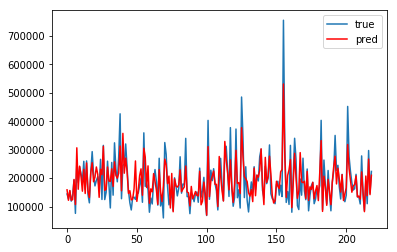

In [193]:
import matplotlib.pyplot as plt

plt.plot(y_test.reset_index(drop=True))
plt.plot(pd.DataFrame(test_y_preds), c='red')
plt.legend(['true', 'pred'])
plt.show()

In [117]:
predictor.endpoint

'sagemaker-pytorch-2019-10-31-08-40-32-459'

In [238]:
predictor.delete_endpoint()

In [440]:
!pygmentize source/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import RegNet

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RegNet(model_info['inputSize'], model_info['outputSize'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.lo

# Deploying model:

In [331]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class HousePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(HousePredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/csv')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='source',
                     predictor_cls=HousePredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

In [332]:
predictor.endpoint

'sagemaker-pytorch-2019-11-04-15-18-15-285'

In [234]:
import boto3
import io
import numpy as np
import pandas as pd
from io import StringIO # python3; python2: BytesIO 

def lambda_handler(event, context):
    bucket='sagemaker-us-west-2-967949086162'
    file_key='housing/mean_house.csv'
    
    runtime = boto3.Session().client('sagemaker-runtime')

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=file_key)
    mean_house = pd.read_csv(io.BytesIO(obj['Body'].read()))
    
    if 'Unnamed: 0' in mean_house.columns.tolist():
        mean_house.drop(['Unnamed: 0'], axis=1, inplace=True)  
    
    #user_vars = event['body']
    
    mean_house['HouseStyle'] = int(event['body'][0])
    mean_house['FullBath'] = int(event['body'][1])
    mean_house = mean_house.astype('int32')
    
    ### change starts here
    test_file = io.StringIO()
    #mean_house = mean_house.iloc[:,1:-1].astype('int32')
    mean_house = mean_house.astype('int32')
    mean_house.to_csv(test_file,header = None, index=False)

    client = boto3.client('sagemaker-runtime')
    response = client.invoke_endpoint(
        EndpointName= 'sagemaker-pytorch-2019-11-04-10-18-55-700',
        Body= test_file.getvalue(),
        ContentType = 'text/csv')
    #### change stops here
    
    #result = response['Body'].read().decode('utf-8')
    result = response['Body'].read()
    
    #result = str(result)[2:-1]

    result = round(float(result), 2)
   
    return {
        'statusCode' : 200,
            'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
            'body' : result
        }


In [235]:
event = {'body':['1', '3']}

In [236]:
house_price = lambda_handler(event, 'd')

In [237]:
house_price

{'statusCode': 200,
 'headers': {'Content-Type': 'text/plain', 'Access-Control-Allow-Origin': '*'},
 'body': 190437.2}

In [333]:
predictor.delete_endpoint()